### Name: Rakesh Kumar K S
### Reg. no: 20BAI1055

### Lab assignment 9 - Transformers

I'll try to use transformers to predict the sentiment of a given text

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("../input/twitterdata/finalSentimentdata2.csv")

In [4]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly thei...
1,1431,joy,if only i could have spent the with this cutie...
2,654,joy,will nature conservation remain a priority in ...
3,2530,sad,coronavirus disappearing in italy show this to...
4,2296,sad,uk records lowest daily virus death toll since...


In [5]:
data.shape

(3090, 3)

Count plot of sentiments,we can see that sad and fear are prevailing which is quite obvious

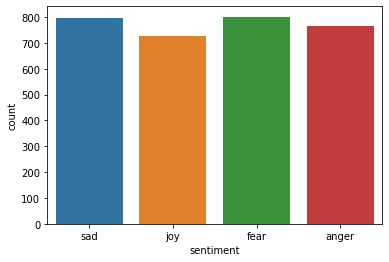

In [6]:
sns.countplot(data['sentiment'])

***Data Preprocessing***

In [7]:
import nltk
import re
import string

A function to clean data it removes all the punctuation marks, urls etc

In [8]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
data['text'] = data['text'].apply(lambda x: clean_text(x))

Function to remove emoji

In [10]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [11]:
data['text']=data['text'].apply(lambda x: remove_emoji(x))

Checking the maximum length of tweet 

In [12]:
data['text'].apply(lambda x:len(str(x).split())).max()

61

**Word cloud of 50 most  common words in India**

In [13]:
from wordcloud import WordCloud, STOPWORDS

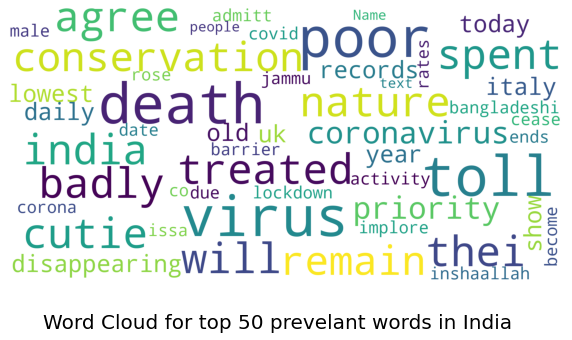

In [14]:
 word_cloud = WordCloud(
                    background_color='white',
                    stopwords=set(STOPWORDS),
                    max_words=50,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(data['text']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
fig.suptitle('Word Cloud for top 50 prevelant words in India', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

Let's  label encode the sentiments

In [15]:
from sklearn.preprocessing import LabelEncoder
lb= LabelEncoder()

In [16]:
lb.fit(data['sentiment'])

LabelEncoder()

In [17]:
classes= list(lb.classes_)

In [18]:
classes

['anger', 'fear', 'joy', 'sad']

In [19]:
data['sentiment']= lb.fit_transform(data['sentiment'])

So basically the encoding is anger-0.fear-1,joy-2,sad-3

In [20]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,3,agree the poor in india are treated badly thei...
1,1431,2,if only i could have spent the with this cutie...
2,654,2,will nature conservation remain a priority in ...
3,2530,3,coronavirus disappearing in italy show this to...
4,2296,3,uk records lowest daily virus death toll since...


In [21]:
import torch
import torch.nn as nn

In [22]:
#importing transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [23]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [24]:
#setting device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
device

device(type='cuda', index=0)

In [26]:
PRE_TRAINED_MODEL_NAME = '../input/bert-base-uncased'

In [27]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [28]:
sample_txt = 'These are tough times we must stand together'

In [29]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: These are tough times we must stand together
   Tokens: ['these', 'are', 'tough', 'times', 'we', 'must', 'stand', 'together']
Token IDs: [2122, 2024, 7823, 2335, 2057, 2442, 3233, 2362]


In [30]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()


dict_keys(['input_ids', 'attention_mask'])

### Choosing Sequence Length for BERT, as it requires fixed sequence length

In [31]:
token_lens = []
for txt in data.text:
    
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token count')

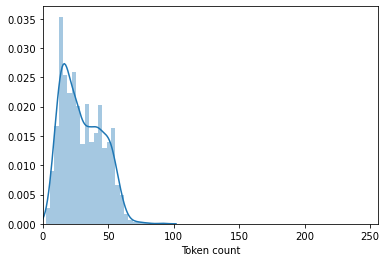

In [32]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the tweets contain less than 100 tokens but we'll be on the safe side and consider maximum length 100

In [33]:
MAX_LEN=100

# Let us create our dataset...

In [34]:
class Covid19Tweet(Dataset):
    
    def __init__(self, tweets, sentiment, tokenizer, max_len):
        
        
        self.tweets = tweets
        self.sentiment = sentiment
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.tweets)
    def __getitem__(self, item):
        
        tweets = str(self.tweets[item])
        sentiment = self.sentiment[item]
        encoding = self.tokenizer.encode_plus(
        tweets,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
        return {
        'tweet_text': tweets,
         'input_ids': encoding['input_ids'].flatten(),
         'attention_mask': encoding['attention_mask'].flatten(),
         'sentiments': torch.tensor(sentiment, dtype=torch.long)
          }

In [35]:
data.head()

,Unnamed: 0,sentiment,text
0,3204,3,agree the poor in india are treated badly thei...
1,1431,2,if only i could have spent the with this cutie...
2,654,2,will nature conservation remain a priority in ...
3,2530,3,coronavirus disappearing in italy show this to...
4,2296,3,uk records lowest daily virus death toll since...


In [36]:
from sklearn.model_selection import train_test_split

In [37]:
train, val = train_test_split(
  data,
  test_size=0.1,
  random_state=RANDOM_SEED
)

In [38]:
train.shape,val.shape

((2781, 3), (309, 3))

Dataloader:-
converts data to be fed into classifier

In [39]:
def create_data_loader(data, tokenizer, max_len, batch_size):
    
    ds = Covid19Tweet(tweets=data.text.to_numpy(),
    sentiment=data.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len)
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4)
BATCH_SIZE = 32
train_data_loader = create_data_loader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val, tokenizer, MAX_LEN, BATCH_SIZE)


In [40]:
df = next(iter(train_data_loader))
df.keys()


dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'sentiments'])

In [41]:
print(df['input_ids'].shape)
print(df['attention_mask'].shape)
print(df['sentiments'].shape)

torch.Size([32, 100])
torch.Size([32, 100])
torch.Size([32])


# BERT MODEL
First we'll define model from pre trained Bert model,
Next we'll  define a class named Sentiment classifier


In [42]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [43]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

In [44]:
n_classes= 4

Let’s create an instance and move it to the GPU

In [45]:
model = SentimentClassifier(n_classes)
model = model.to(device)

In [46]:
input_ids = df['input_ids'].to(device)
attention_mask = df['attention_mask'].to(device)

In [47]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([32, 100])
torch.Size([32, 100])


To get the predicted probabilities from our trained model, we’ll apply the softmax function to the outputs

In [48]:
import torch.nn.functional as F

In [49]:
F.softmax(model(input_ids, attention_mask),dim=1)

tensor([[0.4346, 0.2465, 0.1809, 0.1380],
        [0.3491, 0.2056, 0.3360, 0.1094],
        [0.3056, 0.2536, 0.3020, 0.1388],
        [0.3302, 0.2127, 0.3160, 0.1410],
        [0.3587, 0.2887, 0.1596, 0.1931],
        [0.3295, 0.2111, 0.3218, 0.1376],
        [0.3749, 0.2282, 0.2473, 0.1496],
        [0.3513, 0.2755, 0.2862, 0.0870],
        [0.3382, 0.1882, 0.3660, 0.1076],
        [0.3062, 0.2337, 0.3601, 0.1000],
        [0.3295, 0.2255, 0.3144, 0.1306],
        [0.3656, 0.1865, 0.3250, 0.1229],
        [0.2592, 0.2959, 0.2790, 0.1659],
        [0.2695, 0.2025, 0.4101, 0.1179],
        [0.2955, 0.2481, 0.3133, 0.1431],
        [0.3532, 0.1771, 0.3217, 0.1480],
        [0.3492, 0.2072, 0.3250, 0.1186],
        [0.3581, 0.3022, 0.2577, 0.0820],
        [0.4400, 0.2371, 0.2125, 0.1104],
        [0.3305, 0.1988, 0.3169, 0.1539],
        [0.3307, 0.2019, 0.3632, 0.1042],
        [0.3070, 0.3642, 0.1702, 0.1586],
        [0.3048, 0.2477, 0.3156, 0.1319],
        [0.3710, 0.2118, 0.2290, 0

In [50]:
model.parameters

<bound method Module.parameters of SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [51]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Training with each epoch, it returns loss and accuracy with each step, and use gradient clipping to prrevent gradiemt clipping and optimize each step

In [52]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler, n_examples):  
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["sentiments"].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

We'll do the same with evaluation, except for optimization

In [53]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["sentiments"].to(device)
            outputs = model(input_ids=input_ids,attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
        return correct_predictions.double() / n_examples, np.mean(losses)
            
                

In [54]:
from collections import defaultdict

### Checking how the model improved with each epoch

In [55]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model,train_data_loader,loss_fn,optimizer,device,scheduler,len(train))
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model,val_data_loader,loss_fn,device,len(val))
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.930702276270965 accuracy 0.6051779935275081
Val   loss 0.6903067886829376 accuracy 0.7346278317152104

Epoch 2/10
----------
Train loss 0.43305613109092606 accuracy 0.843581445523193
Val   loss 0.62260502576828 accuracy 0.7734627831715211

Epoch 3/10
----------
Train loss 0.2095230825502297 accuracy 0.9363538295577131
Val   loss 0.7054805755615234 accuracy 0.7896440129449839

Epoch 4/10
----------
Train loss 0.12751422792501832 accuracy 0.9604458827759799
Val   loss 0.9469773590564727 accuracy 0.7605177993527509

Epoch 5/10
----------
Train loss 0.05593662828892127 accuracy 0.9859762675296656
Val   loss 1.0400932490825654 accuracy 0.7766990291262136

Epoch 6/10
----------
Train loss 0.03239463663649285 accuracy 0.9910104279036317
Val   loss 1.1460919082164764 accuracy 0.7669902912621359

Epoch 7/10
----------
Train loss 0.013069475546008211 accuracy 0.9967637540453074
Val   loss 1.2050638377666474 accuracy 0.7734627831715211

Epoch 8/10
----------
Tra

### Plotting a graph of train and validation accuracy vs epochs

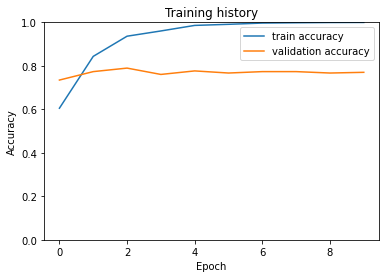

In [56]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Testing our transformer by passing a text input and getting sentiment analysis

In [57]:
review_text = 'Life has come to standstill due to this pandemic, milllions have lost their job '

In [58]:
encoded_review = tokenizer.encode_plus(review_text,max_length=MAX_LEN,add_special_tokens=True,
                                           return_token_type_ids=False,pad_to_max_length=True,return_attention_mask=True,
                                           return_tensors='pt')

In [59]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print('Review text :{}'.format(review_text))
print('Sentiment :{}'.format(classes[prediction]))

Review text :Life has come to standstill due to this pandemic, milllions have lost their job 
Sentiment :sad
